# Applied Data Science Capstone: most similar neighbourhood in another city
*by Eduardo M. de Morais*


# 1. Introduction

## 1.1 Background

São Paulo and Rio de Janeiro are the two largest cities in Brazil. Although relatively close (given the continental dimensions of the country), they have very different characteristics. One of the factors that contribute to the existence of these discrepancies is the obvious geographical distinctions that naturally shape social behavior and, indirectly, the urban structural configuration. The beaches of Rio de Janeiro, for example, give residents a natural option of entertainment and the nearest commercial places have characteristics aimed at this purpose. On the other hand, in São Paulo, entertainment options are directly dependent on experiences that can be provided as a business model.

From a social point of view, Rio de Janeiro inherits aristrocratic characteristics, for having long been the capital of the empire of Brazil. In contrast, the history behind São Paulo's growth is much more associated with commercial reasons. For this reason, the lifestyle in São Paulo tends to be much more pragmatic than in Rio de Janeiro. This characteristic also influences the business model, as there are many more establishments in São Paulo that provide what people do not have time to do.

## 1.2 Problem

We have two of the largest cities in the world with very distinct characteristics: São Paulo and Rio de Janeiro. Locally, each of this places acts like professional centers attracting professionals and companies. Despite the differences mentioned, it is expected that several specific neighborhoods of these cities have characteristics in common. One way to look for this similarity would be to consider the types of venues in each neighborhood. In this way, it would be possible to detect whether a neighborhood has characteristics more focused on commerce, leisure, sports, culture or housing. So, what we need here is a procedure capable of relating neighborhoods, not only from the same city, but also from different cities.


## 1.3 Interest

It is very common for people to have to move to another city. The reasons for this are quite diverse and can involve professional opportunities, personal reasons, among others. This process can be quite difficult for some people, as it involves adapting to a new and possibly different environment. Although two cities may be completely different, they may have neighborhoods with similar characteristics in common. Knowledge of this information can be crucial when choosing a new place to live in a new city. Thus, a person can choose to move to a neighborhood in a new city with similar characteristics to the neighborhood in the city where he lives and is already acclimated.

 Sometimes, a company in one of this cities is interesting in a professional that lives in the other city. Certainly, if the professional find a similiar  neighbourhood, he will be more likely to accept an offer if it is professionally interesting.

# 2. Data

## 2.1 Neighbourhood List
**A** To complete our task, we will need to use some datasets for the analysis approach. First, we need to obtain a data source for the neighborhoods in each of the cities. This can be found on the website `www.guiamais.com.br`:
   - (São Paulo): https://www.guiamais.com.br/bairros/sao-paulo-sp
   - (Rio de Janeiro): https://www.guiamais.com.br/bairros/rio-de-janeiro-rj
   
**B** The next step is obtain the coordinates for each neighbourhood. It can be done using the Nominatim tool, from OpenStreetMap

**C** With the neighbourhoods and its coordinates we can use de Foursquare API to get the venues in each neighbourhood.

<!-- https://pt.wikipedia.org/wiki/Lista_dos_distritos_de_S%C3%A3o_Paulo_por_%C3%8Dndice_de_Desenvolvimento_Humano

https://pt.wikipedia.org/wiki/Lista_de_bairros_do_Rio_de_Janeiro_por_IDH -->

# 3. Methodology

I have to follow the next steps to solve the problem:
1. Scrap the neighbourhood data from the `guiamais.com.br` using BeautifulSoup package. The neighbourhood names are in `li` html tags within a section of class `cities centerContent`. So, what we have to do is to set the BeautifulSoup to read this and get all events inside `<a>` and  `</a>` using python Regex.

2. Gets Coordinates for each Neighbourhood using **nominatim**.

3. Gets the venues in each neighbourhood within a radius of 5km using **Foursquare** API. This is a good value because places at that distance can be accessed quickly by car. Of course, we can select only the venues with smaller distances if we want after request from Foursquare. The max_distance will be a free parameter of the model that I will optimize using and MCMC sample.

4. Count the most common categories of venues. I will consider only the categories that appears more than a specified number of times. This number will be another degree of freedom called min_global_occurences.

5. After this, I  will create a feature for each of this categories checking if the number of times that it appears in each neighbourhood is more than a specified number of times. This parameter will be called min_venue_occurences. If yes, returns 1 and 0 if no.

6. Cluster the data using KMeans. The number of cluster will be a free parameter. 

7. I will find the best values for max_distance, min_global_occurences, min_venue_occurences and number_of_clusters, through a MCMC sample, optimizing a combined score the maximize Silhouette score, Calinski-Harabasz score and minimizes the Davies-Bouldin score.

## 3.1 Importing packages

In [1]:
import pandas as pd
import numpy as np
import re
import requests 
import folium
import pickle
import random
from bs4 import BeautifulSoup
from html import unescape
from tqdm import tqdm
from geopy.geocoders import Nominatim
from functools import reduce
from collections import Counter 

Here, I define the properties of each city and save it in a dictionary:

In [2]:
# Define here the cities and its respectives urls to
# scrap the neighbourhood list
cities = {
    'rj': {
        'name': 'Rio de Janeiro',
        'url':'https://www.guiamais.com.br/bairros/rio-de-janeiro-rj',
        'long_min': -43.694087,
        'long_max': -43.166904,
        'lat_min': -23.047039,
        'lat_max': -22.785521,
    },
    'sp':{
        'name': 'São Paulo',
        'url':'https://www.guiamais.com.br/bairros/sao-paulo-sp',
        'long_min': -46.860478,
        'long_max': -46.137922,
        'lat_min': -23.850532,
        'lat_max': -23.385265,
    }
}

## 3.2 Importing Dataset

The first step is scrap the dataset of neighbourhood information from `guiamais.com.br`. Since we have to do this more than one time, lets define a function for this. To scrap the neighbournames, we just need the url: 

### 3.2.1 Scrap Neighbourhood Information

In [3]:
def scrap_neighbourhoods_from_guiamais(url):
    """Scraps the neighbourhoods list of a city from
    a given url of guiamais.com.br site.
    """

    table = BeautifulSoup(requests.get(url).text, "lxml").find(
        "section", class_="cities centerContent"
    )

    table_string = unescape(str(table.find_all("li")))

    return re.findall('">(.*?)</a', table_string)


Now, we have to scrap the date through the cities and concatenate the information:

In [4]:
def neighbourhood_dataframe(city, neighbourhood_list):
    """ Trasform a list of neighbourhood into dataframe  """
    return pd.DataFrame(
        [(city, nb) for nb in neighbourhood_list], columns=["city", "neighbourhood"]
    )


# Scrapes neighbourhood and creates a pandas dataframe with the result
df = pd.concat(
    [
        neighbourhood_dataframe(
                cities[_]['name'],
                scrap_neighbourhoods_from_guiamais(cities[_]['url'])    
        )  for _ in cities
    ]
).reset_index(drop=True)

In [5]:
# import random
# from IPython.core.display import display, HTML

# city = cities['sp']


# geolocator = Nominatim(user_agent="ny_explorer")
# location = geolocator.geocode(city['name'])
# latitude = location.latitude
# longitude = location.longitude

# # create map of New York using latitude and longitude values
# map_ = folium.Map(location=[latitude, longitude], zoom_start=12)


# # add markers to map
# for (lat, lng, neighborhood,lab,col) in zip(df_cat['latitude'], df_cat['longitude'], df_cat['neighbourhood'], df_cat['labels'], df_cat['color']):
#     label = '{}'.format(neighborhood)
#     label = folium.Popup(label, parse_html=True)
#     folium.CircleMarker(
#         [lat, lng],
#         radius=5,
#         popup=label,
#         color=col,
#         fill=True,
#         fill_color=col,
#         fill_opacity=0.7,
#         parse_html=False).add_to(map_toronto)  


# # file = 'map.html'
# # map_toronto.save(file)
# display(HTML('<a href="'+file+ '" target="_blank">Click here to see the map.</a>'))

# map_

Printing a data sample

In [6]:
print('\n\nSample of data:')
pd.concat(
    [
        df.loc[df['city']=='Rio de Janeiro'].sample(4),
        df.loc[df['city']=='São Paulo'].sample(4),
    ]
)



Sample of data:


,city,neighbourhood
136,Rio de Janeiro,Recreio dos Bandeirantes
85,Rio de Janeiro,Jardim América
166,Rio de Janeiro,Vargem Grande
155,Rio de Janeiro,Senador Vasconcelos
1502,São Paulo,Vila Carioca
922,São Paulo,Jardim Peri Novo
553,São Paulo,Jardim Cris
1764,São Paulo,Vila Nova Pauliceia


### 3.2.2 Gets Coordinates for each Neighbourhood

For each neighbourhood, I will call the nominatim to import the coordinates.

In [7]:
def get_neighbourhood_coord(nominatim, city, neighbourhood):
    """ Gets the coordinate of a neighbourhood """
    
    try:
        location = nominatim.geocode(neighbourhood + " - " + city + ", Brazil")
        return (location.latitude, location.longitude)

    except Exception as inst:
        return (None, None)


As we are working with a large number of neighbourhoods, it is convenient to save the results in a csv file.

In [8]:
if False:
    # instantiate the Nominatim class
    geoloc = Nominatim(user_agent="test_app")

    # Gets the coordinates of all neighbourhoods
    coord_list = [
        get_neighbourhood_coord(geoloc,row['city'],row['neighbourhood']) 
         for index, row in tqdm(df.iterrows(),total = len(df))
    ]

    # Adds the coordinates to neighbourhoods dataframe
    df = pd.concat(
        [
            df,
            pd.DataFrame(coord_list,
                columns=['latitude','longitude'])
        ],
        axis=1
    )

    # Exports the result
    df.to_csv(
        'data/coord'+reduce(lambda x,y: '_'+x+'_'+y,[_ for _ in cities])+'.csv',
        index=False
    )

In [9]:
# Import the dataframe of neighbourhood
df = pd.read_csv( 'data/coord'+reduce(lambda x,y: '_'+x+'_'+y,[_ for _ in cities])+'.csv')

# create a neighbourhood index
df = df.reset_index()

# Remove all neighbourhoods without coordinates
df = df.dropna()

df.drop(index=df[(df['neighbourhood']=='Campos Elíseos') & (df['city']=='São Paulo')].index[0],inplace=True)

In [10]:
print('\n\nSample of data:')
pd.concat(
    [
        df.loc[df['city']=='Rio de Janeiro'].sample(4),
        df.loc[df['city']=='São Paulo'].sample(4),
    ]
)



Sample of data:


,index,city,neighbourhood,latitude,longitude
146,146,Rio de Janeiro,Santa Teresa,-22.921399,-43.188214
66,66,Rio de Janeiro,Gávea,-22.981424,-43.238324
158,158,Rio de Janeiro,Taquara,-22.921886,-43.384646
160,160,Rio de Janeiro,Tijuca,-22.933216,-43.238145
1712,1712,São Paulo,Vila Mazzei,-23.472956,-46.600822
231,231,São Paulo,Casa Verde,-23.505927,-46.656138
637,637,São Paulo,Jardim Ernestina,-21.462115,-48.396833
816,816,São Paulo,Jardim Marilda,-23.426409,-46.514675


### 3.2.3 Gets the venues for each neighbourhood with Foursquare

In order to use the Foursquare, the first step is define the credentials. I have it in a separated csv file that I will import here:

In [11]:
CLIENT_ID,CLIENT_SECRET,ACCESS_TOKEN,VERSION = \
    pd.read_csv('data/credentials.csv').T.to_dict()[0].values()

The approach here is use the explore query from Foursquare, passing the coordinates for each neighbourhood and get the venues. Here, I will set a radius of 5000 km and limit the search in 2000 venues. If the Foursquare do not find any venue, so the fucntion will return an empty dict.

In [12]:
def get_nearby_venues(index,
                      city,
                      neighbourhood,
                      latitude,
                      longitude,
                      radius = 5000,
                      limit = 2000):
    """ Query to explore the neighbourhood places in foursquare api """
            
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        latitude, 
        longitude, 
        radius, 
        limit)

    try:
        return {
            'index': index,
            'city': city,
            'neighbourhood': neighbourhood,
            'result': requests.get(url, timeout=5).json()["response"]['groups'][0]['items']
        }
    except:
        return {
            'index': index,
            'city': city,
            'neighbourhood': neighbourhood,
            'result': None
        }

Here, I'll print an example of output

In [13]:
results = get_nearby_venues(
    df.iloc[60]['index'],
    df.iloc[60]['city'],
    df.iloc[60]['neighbourhood'],
    df.iloc[60]['latitude'],
    df.iloc[60]['longitude'],
    radius = 5000,
    limit = 1000
)
results

{'index': 72,
 'city': 'Rio de Janeiro',
 'neighbourhood': 'Guaratiba',
 'result': [{'reasons': {'count': 0,
    'items': [{'summary': 'This spot is popular',
      'type': 'general',
      'reasonName': 'globalInteractionReason'}]},
   'venue': {'id': '5044d19fe4b08d95c2f5632e',
    'name': 'Bora Bora',
    'location': {'address': 'Estrada do Mato Alto, 3620. Guaratiba',
     'lat': -22.979256944773702,
     'lng': -43.58888687975564,
     'labeledLatLngs': [{'label': 'display',
       'lat': -22.979256944773702,
       'lng': -43.58888687975564}],
     'distance': 1324,
     'cc': 'BR',
     'city': 'Rio de Janeiro',
     'state': 'RJ',
     'country': 'Brasil',
     'formattedAddress': ['Estrada do Mato Alto, 3620. Guaratiba',
      'Rio de Janeiro, RJ',
      'Brasil']},
    'categories': [{'id': '4d954b0ea243a5684a65b473',
      'name': 'Convenience Store',
      'pluralName': 'Convenience Stores',
      'shortName': 'Convenience Store',
      'icon': {'prefix': 'https://ss3.4sqi.

Since it is not a fast procedure, I'll save the results in a pickle file to import whenever I need.

In [14]:
if False:
    
    # Gets the venues for all neighbourhoods
    foursquare_result = [
        get_nearby_venues(
            row['index'],
            row['city'],
            row['neighbourhood'],
            row['latitude'],
            row['longitude'],
            radius = 5000,
            limit = 2000
        )

        for index, row in tqdm(df.iterrows(),total = len(df))
    ]

    pickle.dump(foursquare_result, open("data/foursquare_result.p", "wb" ))
    
foursquare_result = pickle.load(open("data/foursquare_result.p","rb" ))

Now, we have a list of venues. Lets format to put it in a pandas dataframe:

In [15]:
def format_category(category_list):
    return '|'.join(
        [
            cat.get('name','').replace(' / ','|')\
                .replace(' | ','|').replace(' & ','|')\
                    .replace(' ','_')#.replace('_','|')
            for cat in category_list
        ]
    )

# Loop through the venues
list_venues = []

for nb_venues in foursquare_result:
    for result in (nb_venues['result'] or []):
        if result:
            list_venues.append(
                {
                    'id': result['venue']['id'],
                    'nb_index': nb_venues['index'],
                    'name': result['venue']['name'],
                    'categories': format_category(
                        result['venue'].get('categories',[])),
                    'distance': result['venue']['location']['distance'],
                }
            )
        
df_venues = pd.DataFrame(list_venues)


Here, an example of `dv_venues` items:

In [16]:
df_venues.head(8)

,id,nb_index,name,categories,distance
0,4d5dad65f7d7224b54652081,0,Crepe Lieto,Deli|Bodega,93
1,4ba55e8df964a5200a0039e3,0,Rei do Bacalhau,Portuguese_Restaurant,420
2,523e424f11d2b11ae99aa553,0,Esquina do Espeto,Restaurant,350
3,4c6f2ae134443704c360205f,0,Tramelinha,Bar,508
4,5225259811d2d985551c1ba2,0,Sabor do Árabe,Middle_Eastern_Restaurant,1824
5,4b899309f964a520f34232e3,0,Outback Steakhouse,Steakhouse,1910
6,4f13006ce4b019e992bd19e2,0,Kopenhagen,Chocolate_Shop,1719
7,4bb247ae42959c74a49e202c,0,Saraiva MegaStore,Bookstore,1812


### 3.2.4 Merging Dataset

Now, we have two basic datasets. The first is a frame with the neighbourhood list and the second, a frame with the venues. This datasets are linked through the neighbourhood index, called by `index` in neighbourhood list and by `nb_index` in venues list. The first step to merge this is an aggregation function in venues by neighbourhood. But, before this, is important to permit the user to limit the venue distance from neighbourhood coordinate.

In [17]:
def agg_venues_by_nb(X):
    concatenate_categories = lambda series: reduce(lambda x, y: x +'|'+y, series)
    return X.groupby('nb_index').agg({'categories':  concatenate_categories})


def limit_venue_distance(X,max_distance):
    return X[X['distance']<=max_distance]


def merge_categories(df, df_venues, max_distance=1000):

    categories = agg_venues_by_nb(
        limit_venue_distance(df_venues,max_distance=max_distance)
    )

    return pd.merge(
        df,
        categories,
        how = 'inner',
        left_on = 'index',
        right_index = True,
    ).rename(columns={'index':'neighbourhood_id'}).set_index('neighbourhood_id')



Lets see how is the merged dataframe considered all venues within 2km from neighbourhood:

In [18]:
df_merge = merge_categories(df, df_venues, max_distance=2000)
df_merge.sample(3)

,city,neighbourhood,latitude,longitude,categories
neighbourhood_id,,,,,
509,São Paulo,Jardim Campos,-22.828058,-45.216947,Brazilian_Restaurant|Hotel|Bar|Pizza_Place|Bra...
738,São Paulo,Jardim Japão,-23.664577,-47.074028,Grocery_Store
412,São Paulo,Jardim Adelaide,-23.410403,-46.848514,Supermarket|Snack_Place|Japanese_Restaurant|Gy...


## 3.3 Dataset PreProcessing

We have several neighbourhoods and, in each one, several categories. I want to count all categories to see the most commons.

In [19]:
def n_most_common_words(categories,n=None,n_min = 1,n_max = 9999999):

    words_list = '|'.join(categories)

    for char in ['/','&']:
        words_list = words_list.replace(char,'')

    result = Counter(words_list.split('|'))

    if n:
        result =  dict(result.most_common(n))

    else:
        result =  dict(result.most_common())

    return dict((filter(lambda x: (x[1]>=n_min)  and (x[1]<=n_max)  ,result.items())))

In example bellow, we are counting the categories for all venues within 2km inside the neighbourhoods

In [20]:
n_most_common_words(df_merge['categories'],n_min = 100)

{'Gym': 1576,
 'Bakery': 1133,
 'Pizza_Place': 974,
 'Brazilian_Restaurant': 922,
 'Fitness_Center': 920,
 'Bar': 888,
 'Ice_Cream_Shop': 628,
 'Restaurant': 553,
 'Japanese_Restaurant': 487,
 'Burger_Joint': 465,
 'Dessert_Shop': 412,
 'Snack_Place': 383,
 'Hotel': 352,
 'Supermarket': 346,
 'Park': 332,
 'Café': 328,
 'Coffee_Shop': 310,
 'Steakhouse': 304,
 'Italian_Restaurant': 302,
 'Pharmacy': 270,
 'Plaza': 265,
 'Fast_Food_Restaurant': 258,
 'Chocolate_Shop': 253,
 'Pet_Store': 243,
 'Sandwich_Place': 226,
 'BBQ_Joint': 226,
 'Middle_Eastern_Restaurant': 199,
 'Grocery_Store': 199,
 'Market': 183,
 'Food_Truck': 171,
 'Seafood_Restaurant': 167,
 'Farmers_Market': 162,
 'Pastelaria': 159,
 'Gymnastics_Gym': 151,
 'Fruit': 134,
 'Vegetable_Store': 134,
 'Shopping_Mall': 132,
 'Brewery': 128,
 'Theater': 123,
 'Beach': 114,
 'Bookstore': 109,
 'Music_Venue': 106}

In teh function defined below, we will merge `df` will `df_venues`, selecting only the venues within a specified `max_distance` from the neighbourhood coordinates, and the categories appearing more than `n_min` times in all neighbourhoods. In the end, we gonna scale the data. 

In [27]:
from sklearn.preprocessing import MinMaxScaler

def categories_processing(df, df_venues, max_distance=1000, n_min = 5,n_max=999999,
    drop_categories = [], count = True, scale=False, drop_columns = [
    'city', 'neighbourhood', 'latitude', 'longitude', 'categories'],n_cats=3):
    
    df_merge = merge_categories(df, df_venues, max_distance=max_distance)
    
    most_common_words = n_most_common_words(df_merge['categories'],n_min = n_min,n_max=n_max)
    

    for word in most_common_words:
        df_merge[word] = df_merge['categories'].apply(lambda x: x.count(word))

    for col in drop_categories:
        try:
            df_merge = df_merge.drop(columns=col)
        except:
            pass
        
    df_head = df_merge.copy()[drop_columns]
    
    df_cat = df_merge.drop(columns=drop_columns)

    if not count:
        df_cat = df_cat.applymap(lambda x: 1 if x >= n_cats else 0 )
    
 
    if scale:
        scaler = MinMaxScaler(copy=True, feature_range=(0, 1))
        columns = df_cat.columns
        index = df_cat.index
        df_cat = pd.DataFrame(scaler.fit_transform(df_cat))
        df_cat.columns = columns
        df_cat.index = index
        
    df_merge = pd.concat([df_head,df_cat],axis=1)
        
    return df_merge.drop(columns=['categories'])


cat = categories_processing(df, df_venues, 
    max_distance=5000, n_min = 100,n_max=10000,count=True,scale=False)

cat.sample(4)

,city,neighbourhood,latitude,longitude,Gym,Bakery,Pizza_Place,Fitness_Center,Brazilian_Restaurant,Bar,...,Pie_Shop,Boutique,Mountain,Health_Food_Store,Art_Museum,Cocktail_Bar,Salad_Place,Pool,Samba_School,Mediterranean_Restaurant
neighbourhood_id,,,,,,,,,,,,,,,,,,,,,
292,São Paulo,Cidade Júlia,-23.516106,-46.340677,6,9,4,1,10,2,...,0,0,0,0,0,0,0,0,0,0
163,Rio de Janeiro,Tubiacanga,-22.785521,-43.226517,5,2,3,4,0,3,...,1,0,0,0,0,0,1,0,1,0
558,São Paulo,Jardim Cruzeiro,-22.361338,-46.943181,3,0,3,0,2,6,...,0,0,0,0,0,0,0,0,0,0
421,São Paulo,Jardim Alfredo,-21.408374,-48.513937,1,3,4,0,0,3,...,0,0,0,0,0,0,0,0,0,0


In [62]:
def distance_between_two_neighbourhoods(nb_index_1,nb_index2):
    result = None
    try:
        drop_columns = ['city','neighbourhood','latitude','longitude']
        x1 = cat.iloc[nb_index_1].drop(drop_columns).to_numpy()
        x2 = cat.iloc[nb_index2].drop(drop_columns).to_numpy()
        result = np.linalg.norm(x1-x2)
    except:
        pass

    return result

In [67]:
cat_my_neighbour = cat.copy()
my_neighbour = 'Barra Funda'
my_city = 'São Paulo'
new_city = 'Rio de Janeiro'
my_neighbour_index = cat[cat['neighbourhood'].str.contains(my_neighbour)].index[0]

cat_my_neighbour['distances'] = [distance_between_two_neighbourhoods(my_neighbour_index,id_) for id_ in cat.index]

In [70]:
cat_my_neighbour[cat_my_neighbour['city']==new_city].sort_values('distances')

,city,neighbourhood,latitude,longitude,Gym,Bakery,Pizza_Place,Fitness_Center,Brazilian_Restaurant,Bar,...,Boutique,Mountain,Health_Food_Store,Art_Museum,Cocktail_Bar,Salad_Place,Pool,Samba_School,Mediterranean_Restaurant,distances
neighbourhood_id,,,,,,,,,,,,,,,,,,,,,
162,Rio de Janeiro,Tomás Coelho,-22.867698,-43.306088,10,3,3,5,2,8,...,1,0,0,0,0,0,0,1,0,12.206556
171,Rio de Janeiro,Vigário Geral,-22.809533,-43.309704,13,4,4,8,5,8,...,0,0,0,0,0,0,0,1,0,13.266499
166,Rio de Janeiro,Vargem Grande,-22.970791,-43.496891,1,0,1,1,6,3,...,0,0,0,0,0,0,1,0,2,13.928388
161,Rio de Janeiro,Todos Os Santos,-22.894563,-43.285060,7,5,0,6,4,14,...,1,0,0,0,0,0,0,2,0,13.964240
178,Rio de Janeiro,Vista Alegre,-22.829624,-43.315128,16,4,6,7,4,10,...,0,0,0,0,0,0,0,1,0,14.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,Rio de Janeiro,Vaz Lobo,-22.858972,-43.327865,16,6,3,7,4,6,...,0,0,0,0,0,0,0,1,0,27.459060
179,Rio de Janeiro,Zumbi,-22.821278,-43.175861,8,5,3,5,1,7,...,0,0,0,0,0,0,1,1,0,29.546573
121,Rio de Janeiro,Pedra de Guaratiba,-22.998355,-43.638867,0,0,3,0,3,2,...,1,0,0,0,0,0,0,0,0,29.748950


In [52]:
np.min(distances)

12.206555615733702

## 3.4 Optimizing Parameters

The first step is to import the KMeans and the score we will use to eval the model.

In [22]:
from sklearn.cluster import KMeans

from sklearn.metrics import (
    davies_bouldin_score,
    silhouette_score,
    calinski_harabasz_score
)

Here, I am defining the score I will use to optimize the model

In [23]:
def score(data,labels):
    return calinski_harabasz_score(data,labels)
#     return silhouette_score(data,labels)
#     return (calinski_harabasz_score(data,labels) * silhouette_score(data,labels) ) /(1+davies_bouldin_score(data,labels))


The `cluster` function defined bellow will fit a KMeans model and return the score

In [24]:
def cluster(df,df_venues,max_distance=1000,n_min = 5,n_max=999999,drop_categories = [],
    count = True,scale=False,drop_columns = ['city','neighbourhood',
    'latitude','longitude'],n_cats=1,model = KMeans(n_clusters=4)):
    
    cat = categories_processing(df, df_venues, max_distance=max_distance,
        n_min = n_min, n_max=n_max, drop_categories = drop_categories,
        count = count, scale=scale,n_cats=n_cats)
    
    data = cat.drop(columns=drop_columns)
    
    model.fit(data)
    
    cat['labels'] = model.labels_
    
    
    return {
        'data': data,
        'nb_info':cat[drop_columns],
        'labels':cat[['labels']],
        'score':score(data,cat['labels'])
    }

cluster(df,df_venues,max_distance=5000,n_min = 10, n_max=1000, count = False,scale=False,
        model = KMeans(n_clusters=4),n_cats=15)['score']

10022.291372644297

The `cluster_KMeans` function is identical to `cluster`, but accept the hyperparameters of the KMeans class

In [25]:
def cluster_KMeans(df, df_venues, max_distance=5000, n_min = 5, n_max=99999999,
    drop_categories = [], count = True, scale=False,n_clusters=4,
    algorithm='auto',random_state=42,n_cats=1):
    
    return cluster(df, df_venues, max_distance=max_distance, n_min = n_min,n_max=n_max,
        drop_categories = drop_categories, count = count, scale=scale,n_cats=n_cats,
        model = KMeans(n_clusters=n_clusters,algorithm=algorithm,random_state=random_state)
    )

In [26]:
def score_KMeans(max_distance=5000, n_min = 5,n_max=999999,
    drop_categories = [], count = True, scale=False,n_clusters=4,
    algorithm='auto',random_state=42,n_cats=1):
    
    return cluster_KMeans(df, df_venues, max_distance=max_distance, n_min = n_min,
    n_max=n_max,drop_categories = drop_categories, count = count, scale=scale,n_cats=n_cats,
    n_clusters=n_clusters, algorithm=algorithm,random_state=random_state)['score']



score_KMeans(max_distance=900, n_min = 200,n_max=300,
    count = False, scale=True,n_clusters=2,n_cats=5,
    algorithm='auto')
    

2277.0236118090124

Now that we have a function the returns the score for each parametric configuration, lets define a Markov-Chain-Monte-Carlo sample using Metropolis-Hastings algorithm to find the best configuration.

In [218]:
import random
import time
from tqdm import tqdm

params = {
    'max_distance': [i for i in range(4500,5000)],
    'n_min' : [i for i in range(10,100)],
    'n_cats' : [i for i in range(1,5)],
    'n_max' : [i for i in range(800,4000)],
    'count': [False],
    'scale': [True],
#     'drop_categories': [['Restaurant','Gym','Bakery','Bar','Pizza_Place','Brazilian_Restaurant']],
    'n_clusters': [3,4,5,6,7],
    'algorithm' : ['full']}

start = time.time()

x0 = dict([(par[0],random.choice(par[1])) for par in params.items()])
p0 = score_KMeans(**x0)

list_result = []

N = 5

for i in tqdm(range(N)):

    try:
        xi = dict([(par[0],random.choice(par[1])) for par in params.items()])
        pi = score_KMeans(**xi)

        if pi > p0:
            p0 = pi
            x0 = xi
        else:
            u = random.uniform(0.0,1.0)
            if (u < pi/p0):
                p0 = pi
                x0 = xi
    except:
        pass
            
    list_result.append({'index': i,'parameters':x0,'score':p0})
    
end = time.time()

print('time per loop:',(end-start)/N)

time.sleep(1)

100%|██████████| 5/5 [00:08<00:00,  1.78s/it]


time per loop: 2.249241352081299


In [219]:
def merge_two_dicts(x, y):
    z = x.copy()   # start with x's keys and values
    z.update(y)    # modifies z with y's keys and values & returns None
    return z


df_res = pd.DataFrame(
    [
        merge_two_dicts(d['parameters'], {'score':d['score']})
        for d in list_result
    ]
).sort_values('score',ascending=False)
df_res

,max_distance,n_min,n_cats,n_max,count,scale,n_clusters,algorithm,score
0,4892,69,4,2605,False,True,3,full,89.141764
1,4892,69,4,2605,False,True,3,full,89.141764
2,4892,69,4,2605,False,True,3,full,89.141764
4,4522,92,3,3368,False,True,3,full,80.849092
3,4768,53,3,2821,False,True,5,full,53.291869


In [232]:
par = pd.DataFrame(list_result).sort_values('score',ascending=False).iloc[0]['parameters']

# best_model =  cluster_KMeans(df, df_venues, **par)

best_model =  cluster_KMeans(df, df_venues, **par)

df_cluster = pd.merge(best_model['nb_info'],best_model['data'],left_index=True,right_index=True,how='inner')
df_cluster['labels'] = best_model['labels']

colors_list = ['#000000','#3f95d0','#ff0114','#dbb027','#045c5c','#ffa300',]+\
                ['#'+format(random.randint(0,16777215),'x') for i in range(20)]

df_cluster['color'] = df_cluster['labels'].apply(lambda x: colors_list[x])

pd.DataFrame(list_result).sort_values('score',ascending=False)

,index,parameters,score
0,0,"{'max_distance': 4892, 'n_min': 69, 'n_cats': ...",89.141764
1,1,"{'max_distance': 4892, 'n_min': 69, 'n_cats': ...",89.141764
2,2,"{'max_distance': 4892, 'n_min': 69, 'n_cats': ...",89.141764
4,4,"{'max_distance': 4522, 'n_min': 92, 'n_cats': ...",80.849092
3,3,"{'max_distance': 4768, 'n_min': 53, 'n_cats': ...",53.291869


# 4. Results

In [241]:
par

{'max_distance': 4892,
 'n_min': 69,
 'n_cats': 4,
 'n_max': 2605,
 'count': False,
 'scale': True,
 'n_clusters': 3,
 'algorithm': 'full'}

In [233]:
df_gr = df_cluster.iloc[:,4:-1].groupby('labels').mean()

resut = []
for lab in df_gr.index:
    list_ven = df_gr.iloc[lab].sort_values(ascending=False)
    list_ind = list_ven.index
    dict_res = {'label': lab}

    for i in range(len(list_ven)): dict_res.update({'category_'+str(1+i): list_ind[i]})

    resut.append(dict_res)
df_words = pd.DataFrame(resut).T.iloc[1:].head(30)
df_words

,0,1,2
category_1,Restaurant,Food,Restaurant
category_2,Ice_Cream_Shop,Restaurant,Burger_Joint
category_3,Park,Fast_Food_Restaurant,Japanese_Restaurant
category_4,Dessert_Shop,Ice_Cream_Shop,Ice_Cream_Shop
category_5,Steakhouse,Japanese_Restaurant,Dessert_Shop
category_6,Italian_Restaurant,Burger_Joint,Pet_Store
category_7,Hotel,Market,Park
category_8,Coffee_Shop,Dessert_Shop,Café
category_9,Pet_Store,Snack_Place,Italian_Restaurant
category_10,Market,Food_Truck,Steakhouse


## Common Words

Here, we have the categories common to all groups:

In [234]:
col = 0

# words common to all columns
common = set(df_words[0])
for i in range(1,df_words.shape[1]):
    common = common.intersection(set(df_words[i]))
    
pd.DataFrame(common,columns=['common_words'])

,common_words
0,Café
1,Restaurant
2,Park
3,Hotel
4,Seafood_Restaurant
5,Supermarket
6,Plaza
7,Dessert_Shop
8,Italian_Restaurant
9,Pharmacy


In [235]:
pd.DataFrame(
    dict(
        [
            (i,tuple(filter(lambda x: x not in common, df_words[i]))) 
            for i in range(df_words.shape[1])
        ]
    )
)

,0,1,2
0,Theater,Food,Burger_Joint
1,Museum,Fast_Food_Restaurant,Japanese_Restaurant
2,Bookstore,Japanese_Restaurant,BBQ_Joint
3,Cultural_Center,Burger_Joint,Middle_Eastern_Restaurant
4,Historic_Site,Food_Truck,Food
5,Vegetable_Store,BBQ_Joint,Theater
6,Stadium,Chocolate_Shop,Sports
7,Fruit,Sandwich_Place,Pastelaria
8,Middle_Eastern_Restaurant,Farm,Cultural_Center
9,Scenic_Lookout,Pastelaria,Fruit


In [236]:
common = set(df_words[0])

for i in range(1,df_words.shape[1]):
    common = common.intersection(set(df_words[i]))

not_common=[]    
for i in range(df_words.shape[1]):
    list_ = []
    for j in range(df_words.shape[1]):
        if i != j:
            list_.append((i,j,list(set(df_words[i])-set(df_words[j]))))
        not_common.append(list_)



# base_ = not_common[2][0][2]
# for i in range(1,df_words.shape[1]-1):
#     list_ = not_common[2][i][2]
    
#     base_ = list(set(base_)-set(list_))

    
# base_
# # not_common

In [36]:
# set(df_words[0]).difference(set(df_words[1])).difference(set(df_words[2]))

In [37]:
# set(df_words[1]).difference(set(df_words[0])).difference(set(df_words[2]))#.difference(set(df_words[3]))

In [38]:
# set(df_words[2]).difference(set(df_words[0])).difference(set(df_words[1]))#.difference(set(df_words[3]))

In [39]:
# set(df_words[3]).difference(set(df_words[0])).difference(set(df_words[1])).difference(set(df_words[2]))

## São Paulo

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


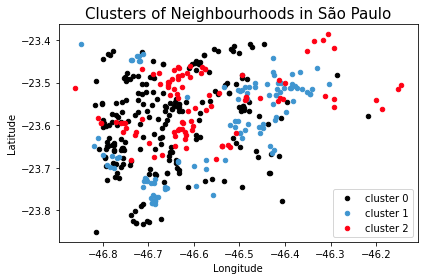

In [242]:
import matplotlib.pyplot as plt
import numpy as np

city = cities['sp']

conditions = df_cluster['city'] == city['name']
conditions &= (df_cluster['latitude'] > city['lat_min']) & (df_cluster['latitude'] < city['lat_max'])
conditions &= (df_cluster['longitude'] > city['long_min']) & (df_cluster['longitude'] < city['long_max'])
df_cat = df_cluster[conditions]

for lab in  np.sort(df_cat['labels'].unique()):
    df_plot = df_cat[df_cat['labels']==lab]
    plt.scatter(df_plot['longitude'],df_plot['latitude'],c=colors_list[lab],s=20,label='cluster '+str(lab))
    
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Clusters of Neighbourhoods in '+city['name'], fontsize=15)
plt.tight_layout()
plt.savefig('clusters_of_neighbourhood-sp.png')
plt.savefig('clusters_of_neighbourhood-sp.eps')
plt.show()

In [229]:
import random
from IPython.core.display import display, HTML

city = cities['sp']


geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(city['name'])
latitude = location.latitude
longitude = location.longitude

# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)


# add markers to map
for (lat, lng, neighborhood,lab,col) in zip(df_cat['latitude'], df_cat['longitude'], df_cat['neighbourhood'], df_cat['labels'], df_cat['color']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=col,
        fill=True,
        fill_color=col,
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  

file = 'map.html'

map_toronto.save(file)
display(HTML('<a href="'+file+ '" target="_blank">Click here to see the map.</a>'))

map_toronto

## Rio de Janeiro

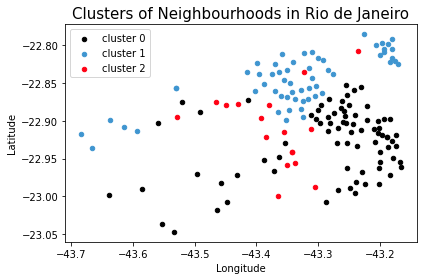

In [239]:
city = cities['rj']

conditions = df_cluster['city'] == city['name']
conditions &= (df_cluster['latitude'] > city['lat_min']) & (df_cluster['latitude'] < city['lat_max'])
conditions &= (df_cluster['longitude'] > city['long_min']) & (df_cluster['longitude'] < city['long_max'])
df_cat = df_cluster[conditions]

for lab in  np.sort(df_cat['labels'].unique()):
    df_plot = df_cat[df_cat['labels']==lab]
    plt.scatter(df_plot['longitude'],df_plot['latitude'],c=colors_list[lab],s=20,label='cluster '+str(lab))
    
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Clusters of Neighbourhoods in '+city['name'], fontsize=15)
plt.tight_layout()
plt.savefig('clusters_of_neighbourhood-rj.png')
plt.show()

In [240]:
import random
from IPython.core.display import display, HTML


geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(city['name'])
latitude = location.latitude
longitude = location.longitude

# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)


# add markers to map
for (lat, lng, neighborhood,lab,col) in zip(df_cat['latitude'], df_cat['longitude'], df_cat['neighbourhood'], df_cat['labels'], df_cat['color']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=col,
        fill=True,
        fill_color=col,
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  

file = 'map.html'

map_toronto.save(file)
display(HTML('<a href="'+file+ '" target="_blank">Click here to see the map.</a>'))

map_toronto

In [174]:
import random
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np

city = cities['rj']

conditions = df_cluster['city'] == city['name']
conditions &= (df_cluster['latitude'] > city['lat_min']) & (df_cluster['latitude'] < city['lat_max'])
conditions &= (df_cluster['longitude'] > city['long_min']) & (df_cluster['longitude'] < city['long_max'])
df_cat = df_cluster[conditions]


geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(city['name'])
latitude = location.latitude
longitude = location.longitude

# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10.4)


# add markers to map
for (lat, lng, neighborhood,lab,col) in zip(df_cat['latitude'], df_cat['longitude'], df_cat['neighbourhood'], df_cat['labels'], df_cat['color']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
#         color='#000000',
        fill=True,
#         fill_color='#000000',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  

file = 'map.html'

map_toronto.save(file)
display(HTML('<a href="'+file+ '" target="_blank">Click here to see the map.</a>'))

map_toronto

# Discussion

# Conclusion